<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A. Checking and Preprocessing

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/Shareddrives/碩士/深度學習產業應用/week9/wsm.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,29.268,29.601,28.899,29.446,686273,0
1,2005-02-28,29.465,29.799,29.354,29.687,485406,0
2,2005-03-01,29.807,30.421,29.799,30.390,918110,0
3,2005-03-02,30.381,30.465,29.850,29.954,610555,0
4,2005-03-03,30.124,30.292,29.379,29.789,671086,0
...,...,...,...,...,...,...,...
3196,2017-11-06,49.800,50.350,49.130,49.930,1190394,0
3197,2017-11-07,49.990,50.000,47.311,47.850,1971540,0
3198,2017-11-08,48.180,48.490,47.730,48.300,1232507,0
3199,2017-11-09,47.850,49.340,47.750,48.960,977143,0


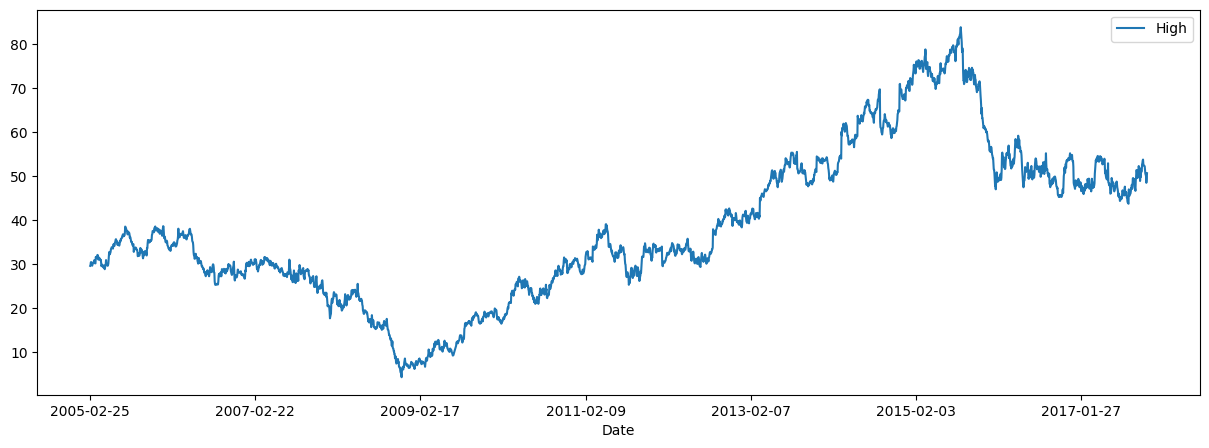

In [ ]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3201 non-null   object 
 1   Open     3201 non-null   float64
 2   High     3201 non-null   float64
 3   Low      3201 non-null   float64
 4   Close    3201 non-null   float64
 5   Volume   3201 non-null   int64  
 6   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 175.2+ KB


In [ ]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(3201, 7)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3201.000000,3201.000000,3201.000000,3201.000000,3.201000e+03,3201.0
mean,37.677572,38.157901,37.204270,37.682312,1.778132e+06,0.0
std,17.229852,17.321629,17.130902,17.224606,1.276739e+06,0.0
min,4.150400,4.270300,3.722500,4.039400,2.526360e+05,0.0
25%,26.778000,27.256000,26.444000,26.879000,9.812220e+05,0.0
50%,33.375000,33.732000,33.033000,33.401000,1.454984e+06,0.0
75%,49.990000,50.643000,49.349000,50.047000,2.178350e+06,0.0
max,83.588000,83.878000,83.033000,83.211000,1.646473e+07,0.0


#### Converting the DataFrame to a NumPy Array

In [ ]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Select features
features = df[['Open', 'Low', 'High', 'Close','Volume']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10, step=15)

# 归一化数据
# 计算均值和标准差
mean_X = X.mean(axis=0, keepdims=True)
std_X = X.std(axis=0, keepdims=True)
# 应用Z得分归一化
X = (X - mean_X) / std_X

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (213, 10, 5)
Shape of data y: (213,)
Shape of data x_train: (153, 10, 5)
Shape of data y_train: (153,)
Shape of data x_val: (39, 10, 5)
Shape of data y_val: (39,)
Shape of data x_test: (21, 10, 5)
Shape of data y_test: (21,)
Number of samples in training and validation are 153 and 39.


## B. Defining Neural Networks

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Dropout layer after LSTM
        self.dropout = nn.Dropout(dropout_prob)

        # First fully connected layer
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)

        # Batch normalization to stabilize the learning
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim * 2)

        # Activation layer
        self.relu1 = nn.ReLU()

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Another batch normalization
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim)

        # Another activation layer
        self.relu2 = nn.ReLU()

        # Final fully connected layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Passing through the LSTM layer
        lstm_out, _ = self.lstm(x)

        # Selecting the output of the last timestep
        lstm_out = lstm_out[:, -1, :]

        # Applying dropout
        out = self.dropout(lstm_out)

        # First fully connected layer
        out = self.fc1(out)

        # Batch normalization and activation
        out = self.batch_norm1(out)
        out = self.relu1(out)

        # Second fully connected layer
        out = self.fc2(out)

        # Second batch normalization and activation
        out = self.batch_norm2(out)
        out = self.relu2(out)

        # Final layer to get the output
        out = self.fc3(out)

        return out

## C. Training the Neural Network

In [ ]:
# Check your GPU status.
!nvidia-smi

Sun Apr 28 06:14:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=5, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(5, 500, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=500, out_features=1000, bias=True)
  (batch_norm1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (batch_norm2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=500, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 1610.6996, Val loss: 1660.6565, Best Val loss: 1660.6565
Epoch 2/100, Train loss: 1489.6819, Val loss: 1543.7234, Best Val loss: 1543.7234
Epoch 3/100, Train loss: 1355.8962, Val loss: 1310.7147, Best Val loss: 1310.7147
Epoch 4/100, Train loss: 1291.6376, Val loss: 1160.4164, Best Val loss: 1160.4164
Epoch 5/100, Train loss: 1207.0044, Val loss: 911.7313, Best Val loss: 911.7313
Epoch 6/100, Train loss: 1116.7016, Val loss: 735.1433, Best Val loss: 735.1433
Epoch 7/100, Train loss: 1052.8050, Val loss: 643.8022, Best Val loss: 643.8022
Epoch 8/100, Train loss: 980.0035, Val loss: 576.5813, Best Val loss: 576.5813
Epoch 9/100, Train loss: 925.9656, Val loss: 550.3724, Best Val loss: 550.3724
Epoch 10/100, Train loss: 809.5233, Val loss: 608.9154, Best Val loss: 550.3724
Epoch 11/100, Train loss: 731.8211, Val loss: 611.7133, Best Val loss: 550.3724
Epoch 12/100, Train loss: 668.0187, Val loss: 447.9575, Best Val loss: 447.9575
Epoch 13/100, Train loss: 589.7369

#### Visualizing the model performance

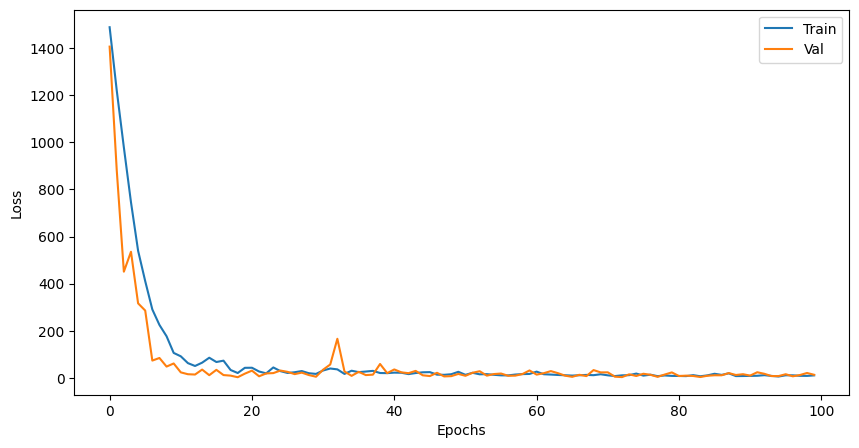

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

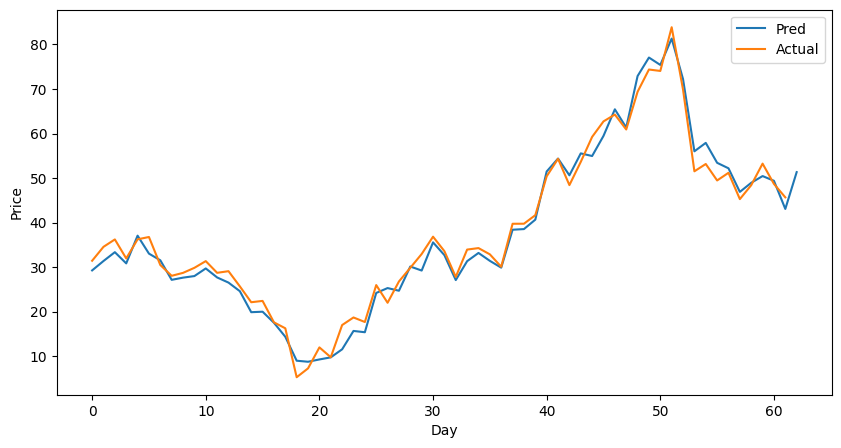

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()